In [15]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [5]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image


In [6]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
epoch_num = 50
lr = 1e-3
batchsize = 32

In [9]:
trainset = datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)

testset = datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)

trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

testloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 32581950.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
def save_recon_image(img, name):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, name)

def make_dir():
    image_dir = 'AE_Conv_CIFAR10_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=0
        )
        self.enc2 = nn.Conv2d(
            in_channels=8, out_channels=8, kernel_size=3,stride=1, padding=0
        )
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=8, out_channels=8, kernel_size=3,stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=8, out_channels=3, kernel_size=3,stride=1, padding=0
        )
    def forward(self, x):
       x = F.relu(self.enc1(x))
       x = F.relu(self.enc2(x))
       x = F.relu(self.dec1(x))
       x = F.relu(self.dec2(x))
       return x
model = Autoencoder()
print(model)

Autoencoder(
  (enc1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (enc2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
)


In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
def train(model, trainloader, epoch_num):
    train_loss = []
    for epoch in range(epoch_num):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data 
            img = img.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch: {} , Train Loss: {:.3f}'.format(
            epoch+1, loss))
        if epoch % 10 == 0:
            save_recon_image(img.cpu().data, name='./AE_Conv_CIFAR10_Images/original{}.png'.format(epoch))
            save_recon_image(outputs.cpu().data, name='./AE_Conv_CIFAR10_Images/decoded{}.png'.format(epoch))
    return train_loss


In [17]:
def test(model, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        outputs = model(img)
        outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data
        save_image(img,'original_image.png')
        save_image(outputs, 'ae_conv_cifar10_reconstruction.png')
        break

cpu
Epoch: 1 , Train Loss: 0.152
Epoch: 2 , Train Loss: 0.145
Epoch: 3 , Train Loss: 0.144
Epoch: 4 , Train Loss: 0.144
Epoch: 5 , Train Loss: 0.144
Epoch: 6 , Train Loss: 0.143
Epoch: 7 , Train Loss: 0.143
Epoch: 8 , Train Loss: 0.143
Epoch: 9 , Train Loss: 0.143
Epoch: 10 , Train Loss: 0.143
Epoch: 11 , Train Loss: 0.143
Epoch: 12 , Train Loss: 0.143
Epoch: 13 , Train Loss: 0.143
Epoch: 14 , Train Loss: 0.143
Epoch: 15 , Train Loss: 0.143
Epoch: 16 , Train Loss: 0.143
Epoch: 17 , Train Loss: 0.143
Epoch: 18 , Train Loss: 0.143
Epoch: 19 , Train Loss: 0.143
Epoch: 20 , Train Loss: 0.143
Epoch: 21 , Train Loss: 0.143
Epoch: 22 , Train Loss: 0.143
Epoch: 23 , Train Loss: 0.143
Epoch: 24 , Train Loss: 0.143
Epoch: 25 , Train Loss: 0.143
Epoch: 26 , Train Loss: 0.143
Epoch: 27 , Train Loss: 0.143
Epoch: 28 , Train Loss: 0.143
Epoch: 29 , Train Loss: 0.143
Epoch: 30 , Train Loss: 0.143
Epoch: 31 , Train Loss: 0.143
Epoch: 32 , Train Loss: 0.143
Epoch: 33 , Train Loss: 0.143
Epoch: 34 , Tra

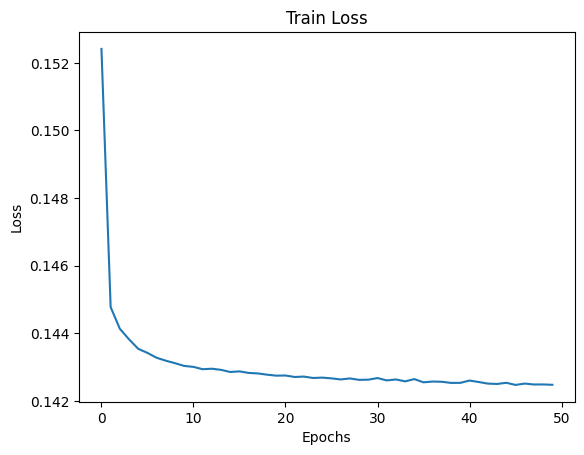

In [18]:
device = get_device()
print(device)
model.to(device)
make_dir()
train_loss = train(model, trainloader, epoch_num)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('conv_ae_cifar10_loss.png')
test(model, testloader)

In [18]:
# from skimage import metrics
# import numpy as np
# def test_compare(model, testloader):
#      avg_psnr=0
#      avg_ssim=0
#      testset_size=0
#      for idx, batch in enumerate(testloader):
#         img, _ = batch
#         img = img.to(device)
#         outputs = model(img)
#         batch_avg_psnr=0
#         batch_avg_ssim=0
#         for i in range(len(img)):
#             original=np.transpose(img[i].detach().cpu(), (1, 2, 0)).numpy()
#             recon=np.transpose(outputs[i].detach().cpu(), (1, 2, 0)).numpy()
#             batch_avg_psnr+=metrics.peak_signal_noise_ratio(original,recon)
#             batch_avg_ssim+=metrics.structural_similarity(original,recon,multichannel=True)
#         avg_psnr+=batch_avg_psnr
#         avg_ssim+=batch_avg_ssim
#         testset_size+=len(img)
#         outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data

#      print("On Test data of {} examples:\nAverage PSNR:{:.3f} \nAverage SSIM: {:.3f}".format(testset_size,avg_psnr/testset_size,avg_ssim/testset_size))
     

In [3]:
# test_compare(model, testloader)

NameError: ignored